### Rice Diseases Classification

### Load Data from kaggle

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"carlodavid012","key":"14f958e0df1fc1c1e7f0f51fc065e737"}'}

In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d minhhuy2810/rice-diseases-image-dataset

In [9]:
!unzip rice-diseases-image-dataset.zip

Archive:  rice-diseases-image-dataset.zip
   creating: Labelled/
   creating: Labelled/LeafBlast/
  inflating: Labelled/LeafBlast/IMG_20190419_095029.jpg  
  inflating: Labelled/LeafBlast/IMG_20190419_095031.jpg  
  inflating: Labelled/LeafBlast/IMG_2973.jpg  
  inflating: Labelled/LeafBlast/IMG_20190419_095429.jpg  
  inflating: Labelled/LeafBlast/IMG_20190419_095439.jpg  
  inflating: Labelled/LeafBlast/IMG_20190419_095523.jpg  
  inflating: Labelled/LeafBlast/IMG_20190419_100501.jpg  
  inflating: Labelled/LeafBlast/IMG_20190419_100509.jpg  
  inflating: Labelled/LeafBlast/IMG_20190419_100511.jpg  
  inflating: Labelled/LeafBlast/IMG_20190419_100539.jpg  
  inflating: Labelled/LeafBlast/IMG_20190419_100544.jpg  
  inflating: Labelled/LeafBlast/IMG_20190419_100547.jpg  
  inflating: Labelled/LeafBlast/IMG_20190419_100605.jpg  
  inflating: Labelled/LeafBlast/IMG_20190419_100614.jpg  
  inflating: Labelled/LeafBlast/IMG_20190419_100616.jpg  
  inflating: Labelled/LeafBlast/IMG_2019041

### import libraries and preprocess data

In [70]:
import torch
from torch import nn, optim
import numpy as np
import os
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline


# check if cuda is available

train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
  print('CUDA is available.  Training on GPU ...')
else:
    print('CUDA is not available!  Training on CPU ...')

CUDA is available.  Training on GPU ...


In [0]:
data_dir = './Labelled'

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(224 + 32),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

image_datasets=dict()
image_datasets['train']=datasets.ImageFolder(data_dir,transform=data_transforms['train'])
image_datasets['valid']=datasets.ImageFolder(data_dir,transform=data_transforms['valid'])

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2


# obtain training indices to use for validation
num_train = len(image_datasets['train'])
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# create dataloaders
train_loader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(image_datasets['valid'], batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)

# specify class names
class_names = image_datasets['train'].classes

In [60]:
print(class_names)

['BrownSpot', 'Healthy', 'Hispa', 'LeafBlast']


### Visualize the Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

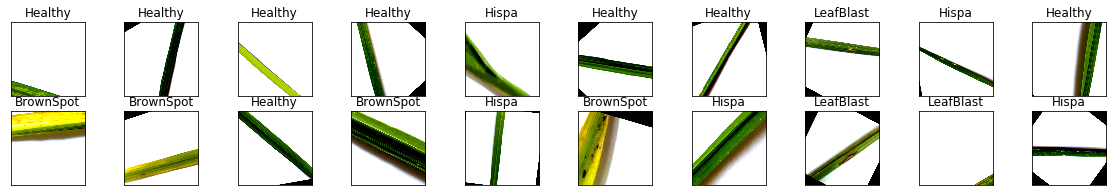

In [62]:
# helper function to un-normalize and display image
def imshow(img):
  img = img / 2 + 0.5
  plt.imshow(np.transpose(img, (1, 2, 0))) #convert from tensor image

# obtain one batch of training images

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in batch with their labels
fig = plt.figure(figsize=(20, 3))
# display 20 images
for idx in np.arange(20):
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title(class_names[labels[idx]])


### Build and train the Classifier

Now the data is ready, we will now build the classifier, we will use pretrained models to achieve high accuracy with less time on training

In [63]:
# download the pretrained model

model = models.resnet152(pretrained=True)

# freeze all pretrained model parameters
for param in model.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth
100%|██████████| 241530880/241530880 [00:02<00:00, 97669547.05it/s]


In [65]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [0]:
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 512)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(512, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

# replace the pretrained model with our classifier
model.fc = classifier

In [72]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [73]:
model.state_dict().keys()

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.0.conv3.weight', 'layer1.0.bn3.weight', 'layer1.0.bn3.bias', 'layer1.0.bn3.running_mean', 'layer1.0.bn3.running_var', 'layer1.0.bn3.num_batches_tracked', 'layer1.0.downsample.0.weight', 'layer1.0.downsample.1.weight', 'layer1.0.downsample.1.bias', 'layer1.0.downsample.1.running_mean', 'layer1.0.downsample.1.running_var', 'layer1.0.downsample.1.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.we

In [0]:
# train model

def train_model(model, criterion, optimizer, scheduler, epochs=25, device='cuda'):
    model.to(device)
    
  
  